# Optical Flow 

References:
       
        https://nanonets.com/blog/optical-flow/
        
        https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html
        
        https://github.com/lmiz100/Optical-flow-Horn-Schunck-method

Submitted By: Jiss Joseph Thomas [CB.EN.P2AID20024]

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


In [2]:
cap = cv2.VideoCapture("dataset\opticalflow\carvideo1.avi")
# cap = cv2.VideoCapture(0)

###  Sparse Optical Flow: Lucas-Kanade method

In [3]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )


In [4]:
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


In [5]:
# Create some random colors
color = np.random.randint(0,255,(100,3))


In [6]:
# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)


In [7]:
# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

In [8]:
while(1):
    ret,frame = cap.read()
    frame=cv2.flip(frame,1)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)
    cv2.imshow('frame',img)
    
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('opticalfb.png',frame)
        cv2.imwrite('opticalhsv.png',img)
        break
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)
cv2.destroyAllWindows()
cap.release()


<ipython-input-8-d2fe6ccfc988>:14: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
<ipython-input-8-d2fe6ccfc988>:15: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)


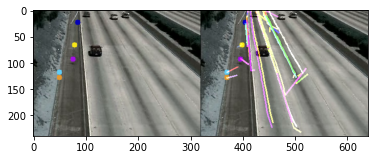

In [9]:
stack = np.hstack((frame, img))
plt.imshow(stack)

### Horn Schunck Method

In [1]:
import cv2
import numpy as np
from scipy.ndimage.filters import convolve as filter2
import os
# from argparse import ArgumentParser


In [2]:
def show_image(name, image):
    if image is None:
        return

    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

In [3]:
#compute magnitude in each 8 pixels. return magnitude average
def get_magnitude(u, v):
    scale = 3
    sum = 0.0
    counter = 0.0

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            counter += 1
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum += magnitude

    mag_avg = sum / counter

    return mag_avg



In [4]:
def draw_quiver(u,v,beforeImg):
    scale = 3
    ax = plt.figure().gca()
    ax.imshow(beforeImg, cmap = 'gray')

    magnitudeAvg = get_magnitude(u, v)

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            #draw only significant changes
            if magnitude > magnitudeAvg:
                ax.arrow(j,i, dx, dy, color = 'red')

    plt.draw()
    plt.show()


In [5]:
#compute derivatives of the image intensity values along the x, y, time
def get_derivatives(img1, img2):
    #derivative masks
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = filter2(img1,x_kernel) + filter2(img2,x_kernel)
    fy = filter2(img1, y_kernel) + filter2(img2, y_kernel)
    ft = filter2(img1, -t_kernel) + filter2(img2, t_kernel)

    return [fx,fy, ft]



In [6]:
#input: images name, smoothing parameter, tolerance
#output: images variations (flow vectors u, v)
#calculates u,v vectors and draw quiver
def computeHS(name1, name2, alpha, delta):
    
   

    beforeImg = cv2.imread(name1, cv2.IMREAD_GRAYSCALE).astype(float)
    afterImg = cv2.imread(name2, cv2.IMREAD_GRAYSCALE).astype(float)

    #removing noise
    beforeImg  = cv2.GaussianBlur(beforeImg, (5, 5), 0)
    afterImg = cv2.GaussianBlur(afterImg, (5, 5), 0)

    # set up initial values
    u = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    v = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    fx, fy, ft = get_derivatives(beforeImg, afterImg)
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                            [1 / 6, 0, 1 / 6],
                            [1 / 12, 1 / 6, 1 / 12]], float)
    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = filter2(u, avg_kernel)
        v_avg = filter2(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)
        #converges check (at most 300 iterations)
        if  diff < delta or iter_counter > 300:
            # print("iteration number: ", iter_counter)
            break

    draw_quiver(u, v, beforeImg)

    return [u, v]



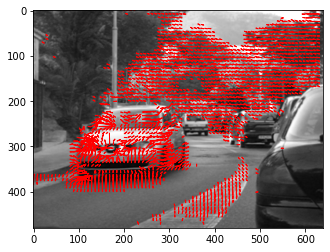

In [9]:


if __name__ == '__main__':
    

    u,v = computeHS("dataset\opticalflow\car1.jpg", "dataset\opticalflow\car2.jpg", alpha = 15, delta = 10**-1)


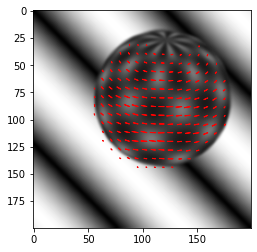

In [7]:
u,v = computeHS("dataset\opticalflow\sphere1.bmp", "dataset\opticalflow\sphere2.bmp", alpha = 15, delta = 10**-1)

### DataGenCode

In [20]:
import random
import sys


In [21]:
key_num = random.SystemRandom()
data = ["ad", "bc", "gh"]
numerical = key_num.randint(100, sys.maxsize)
categorical = random.sample(data, 3)



In [22]:
def query(response):
    if response == "boolean":
        a = random.randint(0, 50)
        return (bin(a)) 

    elif response == "numerical":
         return (random.randint(mini, maxi))
    elif response == "categorical":
         return (random.sample(data, 3))
    else:
        return "no query present"
    
    return response


In [23]:
row = []
nof1 = int(input("Enter the no. of rows: "))
nof2 = int(input("Enter the no. of columns: "))
response=[]
for i in range(nof2):
    response.append(input("Please enter the type of feature: "))
    if response[i] == "numerical":
        mini= input("enter min value: ")
        maxi= input("enter max value: ")

    
for i in range(nof1):
    coloumn=[]
    for j in range(nof2):
        coloumn.append(query(response[j]))
        #print(tabulate(response,tablefmt='plain'))
    row.append(coloumn)
for i in range(nof1):
    print(row[i])





#key_num = random.SystemRandom()
##print(key_num.random()) #produces a number between 0 and 1
##print(key_num.randint(100, sys.maxint)) # produces a integer between 0 and the highest allowed by the OS.
#data = ["ad", "bc", "gh"]
##print[random.sample(data, 4) for _ in xrange(10)]
#for i in range(0, nof1):
#    a = random.randint(0, 5000)
#    print(a), bin(a), key_num.randint(100, sys.maxint), random.sample(data, 3), random.choice(string.ascii_lowercase)
#    



# response = raw_input("Please enter the type of feature: ")



Enter the no. of rows: 2
Enter the no. of columns: 2
Please enter the type of feature: car
Please enter the type of feature: bike
['no query present', 'no query present']
['no query present', 'no query present']


### Dense Optical Flow

In [13]:
cap = cv2.VideoCapture("dataset\opticalflow\carvideo1.avi")

ret, frame1 = cap.read()
frame1=cv2.flip(frame1,1)
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    ret, frame2 = cap.read()
    frame2=cv2.flip(frame2,1)
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)

    #Dense optical flow using Gunnar Farneback’s algorithm
    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    #(prev, next, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags[, flow]) → flow
#     print(flow)

    #Calculates the magnitude and angle of 2D vectors (array operation)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    #Normalizes the norm or value range of an array
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    cv2.imshow('frame2',rgb)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    elif k == ord('s'):
        cv2.imwrite('densefb.png',frame2)
        cv2.imwrite('densehsv.png',rgb)
        break
    prvs = next
    
cap.release()
cv2.destroyAllWindows()

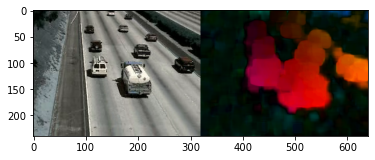

In [14]:
stack = np.hstack((frame2, rgb))
plt.imshow(stack)